# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [38]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8., 8.)

import pickle as cp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import accuracy_score
import warnings; warnings.simplefilter('ignore')  


Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [39]:
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        mean = np.mean(X)
        std = np.maximum(np.std(X),0.001)
        return mean,std
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self,val,mean,std):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        pdf = scipy.stats.norm.pdf(val, mean, std)
        return pdf
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        n = len(set(X))
        p = (np.sum(X)+1)/(len(X)+n)
        return p
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self, val, p):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        den_val =  scipy.stats.bernoulli.pmf(val ,p)
        return den_val
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        p = dict(pd.DataFrame(X).iloc[:,0].value_counts(normalize=True))
        return p
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self, val, p):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################        
        m = np.array([p.get(i,0) for i in val])
        return m
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [40]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################+
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.feature_types = feature_types
        self.num_classes = num_classes
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################       
        self.params = [[0]*len(self.feature_types) for i in range(self.num_classes)]
        #self.params = np.zeros([self.num_classes,len(self.feature_types)])
        self.y_label = list(set(y))
        self.Py = {}
        for i,c in enumerate(self.y_label):
            self.Py[c] = len(y[y==c])/len(y) #prior
            X_c = X[y == c]                             
            for k, j in enumerate(self.feature_types):            
                if j == 'b':
                    B = BinFeatureParam()
                    self.params[i][k] = B.estimate(X_c[:,k])                    
                elif j == 'r':
                    R = ContFeatureParam()
                    self.params[i][k] = R.estimate(X_c[:,k])
                elif j == 'c':
                    C = CatFeatureParam()
                    self.params[i][k] = C.estimate(X_c[:,k])
                else:
                    print('input type error')
 
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        output = []
        self.prob = [0]*self.num_classes
        for i,c in enumerate(self.y_label):
            prior = np.log(self.Py[c])
            self.prob[i] = []
            for k, j in enumerate(self.feature_types): 
                if j == 'b':
                    B = BinFeatureParam()
                    self.prob[i].append(B.get_probability(X[:,k],self.params[i][k]))
                elif j == 'r':
                    R = ContFeatureParam()
                    prob = R.get_probability(X[:,k],self.params[i][k][0],self.params[i][k][1])
                    self.prob[i].append(prob)
                elif j == 'c':
                    C = CatFeatureParam()
                    self.prob[i].append(C.get_probability(X[:,k],self.params[i][k]))
                    
                else:
                    print('input type error')                
            posterior = np.log(np.array(self.prob[i])).sum(axis=0)
            prediction = prior + posterior
            output.append(prediction)
        prediction = np.argmax(output, axis=0)
        return prediction
            
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']
#print(X.type)
np.random.seed(47)
N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [42]:
from sklearn.linear_model import LogisticRegression
def compareNBCvsLR(nbc, lr,X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    N, D = X.shape 
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtest = X[shuffler[Ntrain:]] 
    ytest = y[shuffler[Ntrain:]]
    
    for n in range(num_splits):
        s = int((n+1)*0.1*Ntrain)
        error_lr = []
        error_nbc = []        
        for i in range(num_runs):
            shuffler = np.random.permutation(Ntrain) 
            Xtrain = X[shuffler[:s]] 
            ytrain = y[shuffler[:s]] 

            #print(ytrain)
            lr.fit(Xtrain, ytrain)
            yhat = lr.predict(Xtest)
            error_lr.append(1-np.mean(yhat == ytest))
            
            nbc.fit(Xtrain, ytrain)
            yhat = nbc.predict(Xtest)
            error_nbc.append(1-np.mean(yhat == ytest))            
            
        tst_errs_lr[n] = np.mean(error_lr)
        tst_errs_nbc[n] = np.mean(error_nbc)
        

    return tst_errs_nbc, tst_errs_lr

The utility function below defines the function for plotting. 

In [43]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)


### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

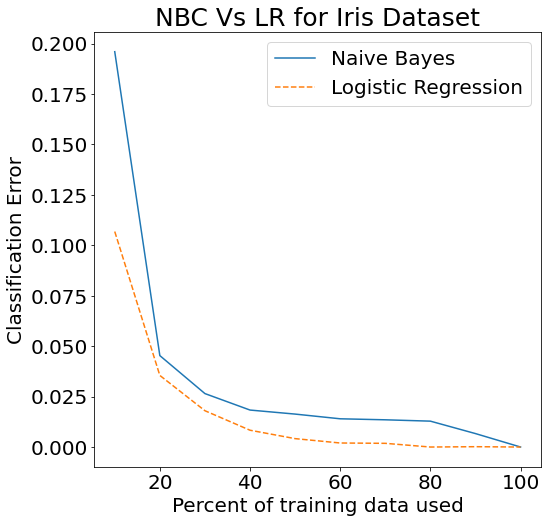

In [44]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names, index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
#iris.info()

iris = shuffle(iris)
X, y = iris.iloc[:,:-1], iris.iloc[:,-1]
X = np.array(X)
y = np.array(y)

lr = LogisticRegression()
nbc = NBC(feature_types=['r']*X.shape[1], num_classes=3)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc,lr,X,y,num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="NBC Vs LR for Iris Dataset")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


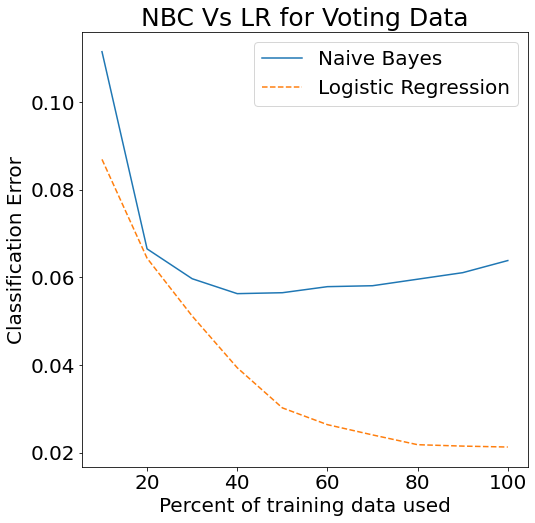

In [45]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')
# voting.info()
voting.dropna(inplace = True)
voting.replace(['n','y','republican','democrat'], [0, 1, 0, 1], inplace=True)
X = np.array(voting.iloc[:,0:])
y = np.array(voting.iloc[:,0])

lr = LogisticRegression()
nbc = NBC(feature_types=['b']*X.shape[1], num_classes=2)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc,lr, X, y,num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="NBC Vs LR for Voting Data")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################


**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

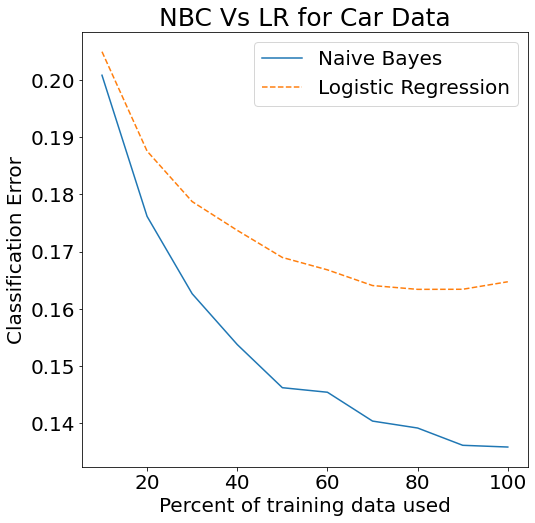

In [46]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
car = pd.read_csv('./datasets/car.csv')
#car.info()
car = shuffle(car)
X = car.drop("acceptability", axis=1)
y = car['acceptability']
y.unique()# 4 categories

# X_encoded = X.apply(LabelEncoder().fit_transform)
# X_encoded = np.array(X_encoded)

X.iloc[:,:2].replace(['low','med','high','vhigh'], [0, 1, 2, 3], inplace=True)
X['doors'].replace('5more', 5, inplace=True)
X.iloc[:,3].replace('more', 5, inplace=True)
X.iloc[:,4].replace(['small','med','big'], [0, 1, 2], inplace=True)
X.iloc[:,5].replace(['low','med','high'], [0, 1, 2], inplace=True)
X = X.astype(int)
X = np.array(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

lr = LogisticRegression()
nbc = NBC(feature_types=['c','c','r','c','c','c'], num_classes=4)

test_err_nbc, test_err_lr = compareNBCvsLR(nbc,lr,X, y_encoded,num_runs=200, num_splits=10)
makePlot(test_err_nbc, test_err_lr, title= "NBC Vs LR for Car Data")

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

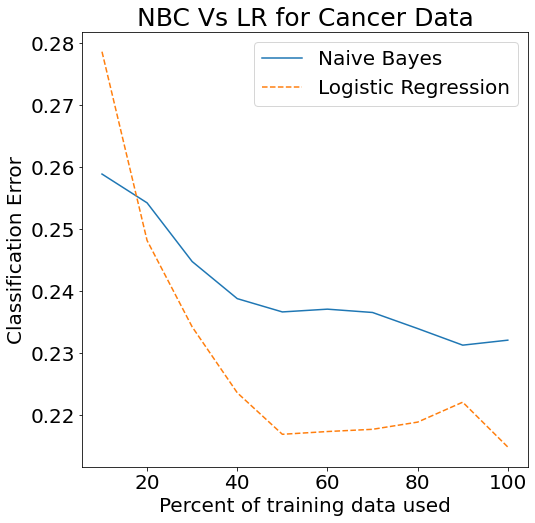

In [47]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
cancer = pd.read_csv('./datasets/breast-cancer.csv')
#cancer.info()
cancer = shuffle(cancer)
cancer =cancer.astype(str)
#cancer[cancer.columns].isnull().sum() 
cancer_clean = cancer[(cancer != '?').all(axis=1)]
#cancer_clean.info() #277 rows after drop

y = cancer_clean[["Class"]]
#y.value_counts() # 2 classes

X = cancer_clean.drop("Class", axis=1)

# X['age'].replace(['20-29','30-39','40-49','50-59','60-69','70-79'], [0, 0, 1, 2, 3, 3], inplace=True)
X['age'].replace(['20-29','30-39','40-49','50-59','60-69','70-79'], [25, 35, 45, 55, 65, 75], inplace=True)
'''20-29 and 70-79 only have 1 and 5 people respectively, while other groups have 36 to 91. 
We therefore combined the two groups with their nearby groups.'''
X['menopause'].replace(['lt40','ge40','premeno'],[0,1,2], inplace=True)
X['tumor-size'].replace(['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54'], 
                     [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8], inplace=True)
# X['tumor-size'].replace(['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54'], 
#                      [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52], inplace=True)
X['inv-nodes'].replace(['0-2','3-5','6-8','9-11','12-14','15-17','24-26'], [0, 1, 2, 3, 4, 4, 4], inplace=True)
# X['inv-nodes'].replace(['0-2','3-5','6-8','9-11','12-14','15-17','24-26'], [1, 4, 7, 10, 13, 16, 25], inplace=True)
X['node-caps'].replace(['no','yes'],[0,1], inplace=True)
X['deg-malig'] = X['deg-malig'].astype(int)
X['breast'].replace(['left','right'],[0,1], inplace=True)
X['irradiat'].replace(['no','yes'],[0,1], inplace=True)
X = pd.concat([X, pd.get_dummies(X['breast-quad'])], axis=1)
X = X.drop('breast-quad', axis=1)

X = np.array(X)
        
le = LabelEncoder()
y_encoded = le.fit_transform(y)

lr = LogisticRegression()
nbc = NBC(feature_types=['r','c','c','c','b','c','b','b','b','b','b','b','b'], num_classes=2)

test_err_nbc, test_err_lr = compareNBCvsLR(nbc,lr,X,y_encoded,num_runs=200, num_splits=10)

makePlot(test_err_nbc, test_err_lr, title= "NBC Vs LR for Cancer Data")

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

[0.21309859 0.19711268 0.19394366 0.18971831 0.1865493  0.18133803
 0.18169014 0.17605634 0.1728169  0.16901408] [0.20760563 0.17619718 0.165      0.16239437 0.15647887 0.15711268
 0.15464789 0.15295775 0.15274648 0.14084507]


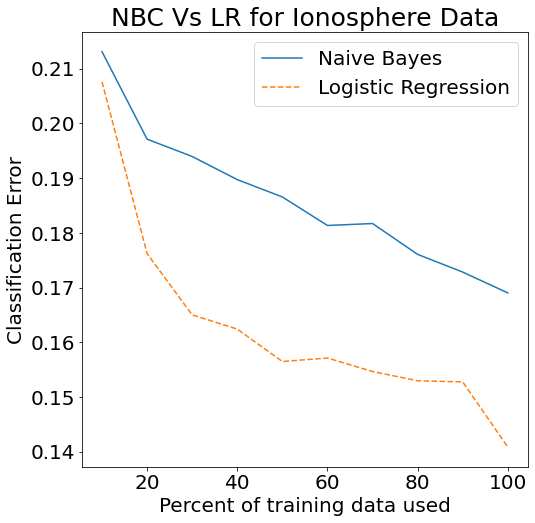

In [54]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
ionosphere = pd.read_csv('./datasets/ionosphere.csv')
#ionosphere.info()
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
ionosphere.dropna(inplace = True)
ionosphere.replace(['g','b'], [0, 1], inplace=True)
X, y = ionosphere.iloc[:,0:34].values, ionosphere['label']

lr = LogisticRegression()
nbc = NBC(feature_types=['r']*34, num_classes=2)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc,lr,X,y,num_runs=200,num_splits=10)
print(tst_errs_nbc, tst_errs_lr)
makePlot(tst_errs_nbc, tst_errs_lr, title= "NBC Vs LR for Ionosphere Data")

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

[0.34261905 0.29190476 0.27607143 0.26892857 0.2597619  0.24940476
 0.25130952 0.24619048 0.24083333 0.23809524] [0.48452381 0.43595238 0.3875     0.32833333 0.30619048 0.27238095
 0.25571429 0.24559524 0.24       0.21428571]


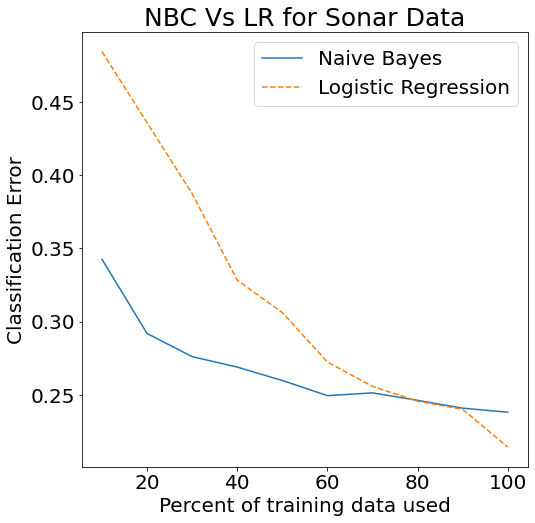

In [49]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
sonar = pd.read_csv('./datasets/sonar.csv')
#sonar.info()

sonar = shuffle(sonar)
X, y = sonar.iloc[:,0:60].values, sonar['label'].values
#print(X)
X = normalize(X)
#print(X)
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
yhat = lr.predict(Xtest)
nbc = NBC(feature_types=['r']*60, num_classes=2)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc,lr,X,y,num_runs=200,num_splits=10)
print(tst_errs_nbc, tst_errs_lr)
makePlot(tst_errs_nbc, tst_errs_lr, title= "NBC Vs LR for Sonar Data")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

## Short Report

In this practical, we compared the performance of Navie Bayesian Classifier and Logistic Regression Classifier. By implementing a Navie Bayesian Classifier based on three different types of features of data, and importing the logistic regression classifier from sklearn, 6 datasets were used for this experiment. 

1.The Iris dataset, we have shuffled the whole dataset at the first place to make sure the sample contains data from all classes. Target data contains 3 classes. By comparing NBC and LR classifiers, the plot has shown the overall trend, logistic regression classifer has better performance than NBC classifier as more and more data used, while NBC shows a rapid decreasing at the begining. 

2.The Voting dataset. Rows contaning missing value has been dropped. All values of 'n' and 'y' has been replaced by 0 and 1; target column contains two classes, and the text of 'republican' and 'democrat' has been replaced as 0 and 1. After comparison, LR has shown a better performance than NBC, although the slope of NBC is steeper than the NBC when 20% data were used.  

3.The Car dataset. Data was clean, and no missing data, except most of value was in the form of text. There were 4 classes in the target. Since the distribution of each classes from target data had a large difference, we shuffled the whole dataset at first in order to make sure all classes data were contained in the sample. The feature of "doors" interpreted as continuous, and features of "persons"; "lug_boot" and "safety" has been altered to be categorical with order. From the plot, it is obvious to show that NBC has better performance than LR when 100% data were used.

4.The Breast cancer data. Rows containing "?" has been removed from the dataset. Shuffling whole dataset has been implemented for the same reason as dataset3. The first feature "age" has been interpreted as continuous; features of "menopause"; "tumor size"; "inv_nodes" and "deg_malig" are interpreted as categorical with ordering, and other features are dealt with binary, in which text values has been replaced as 0 and 1. By comparing, LR is significantly better than NBC. The slope of LR is steeper than the NBC. When 20% data were used, NBC performed better, but as more and more data used, LR catches up quicker over the NBC. 

5.The Ionosphere data. Rows with missing value were removed. Two classes of 'g' and 'b' from target data were converted to 0 and 1. From the original dataset description, the first two columns 'feature1' and 'feature2' were continuous, but they containing only 0 and 1. Thus, we have compare both interpretaions of feature types. First, treating all columns as continuous, the plot shows both classifiers have decreasing trend, and LR is better than NBC. There is no too much difference when less data were used; when more and more data used, the error difference become larger and larger. However, trying with first two culumns as binary, the plot shows a large difference between two classifiers. The NBC performed an increaseing trend, and the LR performed a deacreased trend. Thus, we decided the interpretation of all continuous features is better.

6.The Sonar data. Data were clean, no missing value, 60 continuous features. Target data contains 2 classes, 0 and 1. Shuffling data at the first. X dataset has been normalized before fitting. After comparing, the plot shows the trend of LR has better performance than NBC when more than 80% data used, although the performance of NBC is flatter than the LR, and has lower classification error when less than 80% data used. 

Overall, by experimenting these 6 different data sets, the NBC and LR classifier have a different performance. Sometimes, NBC is better than LR. But on average, error decreased quickly for NBC at the begining; while time goes on, the LR catches up better performance over the NBC. 

- Difficulties we faced: 
    - For categorical feature, we were not sure which feature type to use after one hot encoding. 
    - Due to the distribution of data, the sample cannot gurantee all classes were contained. 
    - Hesitated of one hot encoding or feature encoding.
    
- Lessons we learnt:
    - laplace smooth need to be added; 
    - Converted to log space when calculating the NBC;
    - One hot encoding will handle the text data, but dimention of data has changed;
    - Different interpretation of feature types will generate different results
    
For this practical, we have discussed the first task and second task together. Later on, we mainly assigned the dataset to 3 people, 2 of each.
    